# Revisão da temperatura

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
from glob import glob
from termcolor import colored

import utils as xu

## Preparação dos dados

### Funções

In [2]:
def formatted_print(text, color=None, bold=False, end='\n'):
    """
    Print a string `text` using `color` (str) with a bold
    weight in `bold` (bool) is True, ends the line with `end`
    (str).
    """
    text = str(text)
    
    if bold:
        print(xu.Bold(colored(text, color)), end=end)
    else:
        print(colored(text, color), end=end)

In [3]:
def print_one_event(row_series):
    """
    Pretty print info about an entry in a proposição's tramitação.
    """
    try:
        data = row_series['data'].strftime('%Y-%m-%d %H:%M:%S')
    except:
        data = row_series['data']
        
    # Instante:
    formatted_print('({})'.format(row_series['sequencia']), 'blue', bold=True, end=' ')
    formatted_print(data, bold=True, end = ' - ')
    
    # Local:
    formatted_print('[{}] '.format(row_series['casa']), 'green', bold=True, end='')
    formatted_print('{} >> '.format(row_series['origem_tramitacao_local_nome_casa_local']), 'green', bold=True, end='')
    formatted_print('[{}]'.format(row_series['local']), 'green', bold=True, end=' ')
    formatted_print(row_series['sigla_local'], 'green', bold=True, end=' : ')
    
    # Situação:
    formatted_print(row_series['global'], 'red', end=' ')
    formatted_print('<{}> - '.format(row_series['fase']), 'red', end='')
    #formatted_print('[{}]'.format(row_series['situacao_descricao_situacao']), 'red', end=' ')
    formatted_print('{}'.format(row_series['descricao_situacao']), 'red', end=' ! ')
    
    # Ação legislativa:
    formatted_print('[{}]'.format(row_series['evento']), 'blue', bold=True, end=' ')
    formatted_print('{}'.format(row_series['titulo_evento']), 'blue', bold=True, end=' - ')
    
    # Outros:
    formatted_print('{}'.format(row_series['tipo_documento']), end=' ')
    formatted_print('{}'.format(row_series['nivel']), end=' ')
    formatted_print('({})'.format(row_series['status']), bold=True)

    print(row_series['texto_tramitacao'])

In [4]:
def print_header(df):
    """
    Print fixed info about a proposição.
    """
    pid_casa  = df[['id_ext', 'casa']].drop_duplicates()
    
    for i in range(len(pid_casa)):
        row = pid_casa.iloc[i]
        formatted_print(row['id_ext'], bold=True, end=' ')
        formatted_print('({})'.format(row['casa']), bold=True, end=' --> ')
        if row['casa'] == 'camara':
            formatted_print('https://www.camara.leg.br/proposicoesWeb/fichadetramitacao?idProposicao={}'.format(row['id_ext']))
        else:
            formatted_print('https://www25.senado.leg.br/web/atividade/materias/-/materia/{}'.format(row['id_ext']))
            
    # Print field names:
    col_names = pd.Series(df.columns, index=df.columns)
    print_one_event(col_names)

In [5]:
def print_tramitacao(tram):
    """
    Pretty print tramitação of one proposição 
    listed in DataFrame `tram`.
    """
    # Print tramitação:
    print_header(tram)
    print('')
    for i in range(len(tram)):
        row = tram.iloc[i]
        print_one_event(row)
        print('')

In [6]:
def build_leggo_id_unifier(proposicoes_df):
    """
    Identify proposições that are the same but have 
    different Leggo IDs through the use of their 
    external IDs and create a translating function
    that can group the Leggo IDs into a single one.
    
    Input : proposicoes_df : DataFrame
        A dataframe with the columns 'íd_ext' and 
        'id_leggo'.
    """
    
    # Count the repetitions of external IDs:
    id_ext_entries = proposicoes_df['id_ext'].value_counts()
    # Select the ones that repeat:
    repeated_id_ext = id_ext_entries.loc[id_ext_entries > 1].index
    # Verifica que um ID externo se repete no máximo duas vezes:
    assert id_ext_entries.max() <=2

    # For each one, get their Leggo IDs:
    id_leggo_arrays = proposicoes_df.loc[proposicoes_df['id_ext'].isin(repeated_id_ext)].groupby('id_ext')['id_leggo'].unique()
    # Create a dict that translates one Leggo ID to another:
    leggo_id_unifier = dict(zip(id_leggo_arrays.apply(lambda x: x[0]), id_leggo_arrays.apply(lambda x: x[1])))

    return xu.translate_dict(leggo_id_unifier)

In [7]:
def select_one_tramitacao(trams_df, unique_id_leggo, na_position='last'):
    """
    Select from `trams_df`  (DataFrame all tramitações of 
    many proposições) the tramitação of a single proposição 
    identified by `unique_id_leggo` (str) column.
    
    Return a DataFrame of tramitações in chronological 
    order.
    """
    tramitacao = trams_df.loc[trams_df['unique_id_leggo'] == unique_id_leggo].sort_values(['data', 'sequencia'], na_position=na_position)
    
    return tramitacao

In [8]:
def get_time_interval(tramitacoes, id_columns='unique_id_leggo', sort_columns=['data', 'sequencia'], diff_columns='data', name='delta_days'):
    """
    Compute the time interval (in days) between entries in 
    DataFrame `tramitacoes` of the same ID.
    
    Return : Series
        A Series with the number of days between the 
        current and previous entries in `tramitacoes`.
    """
    
    # Compute time difference between events:
    delta_days = xu.compute_differences_for_fixed_id(tramitacoes, id_columns, sort_columns, diff_columns)
    delta_days = delta_days.dt.total_seconds() / 3600 / 24
    
    delta_days.name = name
    
    return delta_days

In [9]:
def select_relevant_events(tramitacoes, relevant_markers):
    """
    Select entries from `tramitacoes` (DataFrame) that 
    have at least one non-null value  in the columns 
    listed in `relevant_markers` (str, int or list).
    
    Return a DataFrame.
    """
    
    sel_tramitacoes = tramitacoes.loc[~tramitacoes[relevant_markers].isnull().product(axis=1).astype(bool)]
    
    return sel_tramitacoes

In [10]:
def fillna_fixed_tram(df_trams):
    """
    Fill missing values if a tramitações DataFrame
    `df_trams` where every proposição has the same 
    number of entries. 
    
    PS: `df` must be sorted by prop. id and date 
    (descending) and missing values must be placed 
    first.
    """
    
    for col in df_trams.columns:
        
        if col in ['casa', 'data']:
            df_trams[col].fillna(method='bfill', inplace=True)
            
        if col in ['local', 'sigla_local', 'descricao_situacao', 'evento', 'titulo_evento']:
            df_trams[col].fillna('XXXXXX', inplace=True)
            
        if col in ['nivel']:
            df_trams[col].fillna(4, inplace=True)
            
        if col in ['sequencia', 'delta_days', 'acoes_vazias']:
            df_trams[col].fillna(0, inplace=True)
            
    return df_trams

In [11]:
def fillna_relevant_tram(df_trams, event_identifier):
    """
    Fill missing values in `df`, a DataFrame with
    tramitações of many proposições.
    
    PS: Currently it also eliminates missing dates 
    in 'data' column. This may be improved by using 
    information from the 'sequencia' column.
    """
    
    # Fill missing event identifiers:
    for col in event_identifier:
        df_trams[col].fillna('XXXXXX', inplace=True)

    # Set missing time intervals (should always be for the first action of each proposition) to zero:
    df_trams['delta_days'].fillna(0, inplace=True)

    # Remove entries without dates:
    df_trams = df_trams.loc[~df_trams['data'].isnull()]    

    # Não deveriam haver mais valores faltantes:
    assert df_trams.isna().sum().sum() == 0
    
    return df_trams

In [12]:
def crop_and_pad_trams(df_trams, last_n_actions, id_cols, sorter_cols):
    """
    Standardize the number of actions (entries) per 
    proposição by cropping and padding actions.
    
    Input
    -----
    
    df_trams : DataFrame
        Description of tramitações of many 
        proposições.
        
    last_n_actions : int
        Number of the last actions (entries) for 
        each proposição to keep in the dataset.
    
    id_cols : list of str
        Columns used to identify a proposição
        (e.g. [unique_id_leggo]).
    
    sorter_cols : list of str
        Columns used to sort tramitações for
        each proposição (e.g. ['data', 'sequencia']).
        
    Return
    ------
    
    fixed_tramitacoes : DataFrame
        Standardized tramitações, where all proposições 
        have the same number of actions. If the original 
        number of actions is lower than `last_n_actions`
        for a certain proposição, pad (backward fill) 
        the tramitações.
    """
    
    # Não deveriam haver valores faltantes:
    assert df_trams.isna().sum().sum() == 0
    
    # Seleciona as últimas `last_n_actions` de cada proposição: 
    last_tramitacoes = df_trams.sort_values(sorter_cols).groupby(id_cols, sort=True).tail(last_n_actions)

    # Contabiliza número que falta de ações para cada proposição:
    n_empty_actions = last_n_actions - last_tramitacoes.groupby(id_cols).size()

    # Cria ações vazias para proposições com poucas ações:
    empty_series = n_empty_actions.loc[n_empty_actions > 0].map(lambda n: [n] * n).explode()
    empty_series.name = 'acoes_vazias'

    # Coloca ações vazias na base para padronizar número de ações:
    fixed_tramitacoes = pd.concat([empty_series.reset_index(), last_tramitacoes], ignore_index=True).sort_values(id_cols + sorter_cols, na_position='first')

    # Define valores para ações vazias:
    fixed_tramitacoes = fillna_fixed_tram(fixed_tramitacoes)
    
    return fixed_tramitacoes

### Limpeza e organização dos dados

* Reparei que uma mesma proposição pode receber mais de um ID leggo.
* **Atenção:** algumas proposições na tramitação não estão listadas na base de proposições.
* Todas as informações da coluna `situacao_descricao_situacao` estão contidas na coluna `descricao_situacao`. A última contém informações para a Câmara e para o Senao, enquanto que a primeira só contém informações para o Senado. 
* Quase todas as informações presentes na coluna `titulo_evento` estão contidas na coluna `evento`. Uma diferença é que a coluna `titulo_evento` possui, em alguns casos, campos vazios. Os poucos casos nos quais as informações são diferentes são os eventos: `transformada_em_norma_juridica` (senado); e `req_apresentacao`, `req_arquivado`, `req_deferido` e `req_indeferido` (nesses casos, o `titulo_evento` traz informações sobre o tipo de requerimento).

In [13]:
# Carrega lista de arquivos
data_files = sorted(glob('../dados/proposicoes_processadas_2011_2021_part01/*.csv'))
data_files

['../dados/proposicoes_processadas_2011_2021_part01/hists_temperatura.csv',
 '../dados/proposicoes_processadas_2011_2021_part01/interesses.csv',
 '../dados/proposicoes_processadas_2011_2021_part01/proposicoes.csv',
 '../dados/proposicoes_processadas_2011_2021_part01/proposicoes_nao_capturadas.csv',
 '../dados/proposicoes_processadas_2011_2021_part01/trams.csv']

In [14]:
# Carrega dados de proposições:
proposicoes = pd.read_csv(data_files[2])

In [15]:
# Create a dict to group ID leggos referring to the same proposição:
leggo_id_grouper = build_leggo_id_unifier(proposicoes)

# Create a unique link to ID leggos:
proposicoes['unique_id_leggo'] = proposicoes['id_leggo'].map(leggo_id_grouper)
leggo_ids = proposicoes[['id_ext', 'unique_id_leggo']].drop_duplicates().set_index('id_ext')

In [16]:
# Carrega e prepara os dados de tramitações:
trams = pd.read_csv('../dados/proposicoes_processadas_2011_2021_part01/trams.csv', low_memory=False)
trams['data'] = pd.to_datetime(trams['data'])

# Confirma que uma id_ext corresponde à tramitação em uma casa específica:
assert trams.groupby('id_ext')['casa'].nunique().sort_values().max() == 1

In [17]:
# Existem proposições sem id do leggo:
n_missing = len(set(trams['id_ext']) - set(proposicoes['id_ext']))
if n_missing > 0:
    print('Existem {} proposições na base de tramitações não listadas na base de proposições.'.format(n_missing))

Existem 942 proposições na base de tramitações não listadas na base de proposições.


In [18]:
# Identifica a tramitação da mesma proposição em múltiplas casas via ID leggo:
congresso_trams = trams.join(leggo_ids, on='id_ext')
assert len(congresso_trams) == len(trams)

# Preenche os IDs faltantes com IDs externos.
congresso_trams['unique_id_leggo'].fillna(congresso_trams['id_ext'].astype(str), inplace=True)

# Cria série de tipo de proposições:
sigla_tipo_order  = {'MPV': 0, 'PEC': 1, 'PLP':2, 'PDS': 3, 'PLV': 4, 'PLN': 5, 'PL': 6, 'PLC': 7, 'PLS': 8}
sigla_tipo_series = proposicoes.groupby('unique_id_leggo')['sigla_tipo'].unique().apply(lambda x: xu.pick_representative(x, sigla_tipo_order))
# Junta à base:
congresso_trams = congresso_trams.join(sigla_tipo_series, on='unique_id_leggo')

### Processando os dados para virar _features_

In [19]:
relevant_cols    = ['unique_id_leggo', 'casa', 'local', 'sigla_local', 'descricao_situacao', 'evento', 'titulo_evento', 'nivel', 'data', 'sequencia']
event_identifier = ['descricao_situacao', 'evento', 'titulo_evento']
prop_id          = ['unique_id_leggo']
sorter_cols      = ['data', 'sequencia']   
last_n_actions   = 5

# Select events that have at least one entry in one of the `event_identifier` columns:
relevant_tramitacoes = select_relevant_events(congresso_trams, event_identifier)[relevant_cols]
# Add time interval between events:
relevant_tramitacoes = relevant_tramitacoes.join(get_time_interval(relevant_tramitacoes))

# Fill missing values (and remove missing dates):
relevant_tramitacoes = fillna_relevant_tram(relevant_tramitacoes, event_identifier)

# Standardize the number of actions per proposição:
fixed_tramitacoes = crop_and_pad_trams(relevant_tramitacoes, last_n_actions, prop_id, sorter_cols)

In [21]:
fixed_tramitacoes.head(20)

,unique_id_leggo,acoes_vazias,casa,local,sigla_local,descricao_situacao,evento,titulo_evento,nivel,data,sequencia,delta_days
165567,00010b1ea1accfc1b6f15cd5f36603b7,0,camara,CCJC,CCJC,Pronta para Pauta,designado_relator,Designação de Relator,1.0,2019-09-30 00:00:00+00:00,55.0,156.277778
165688,00010b1ea1accfc1b6f15cd5f36603b7,0,camara,CCJC,CCJC,Pronta para Pauta,XXXXXX,XXXXXX,4.0,2019-10-01 00:00:00+00:00,56.0,1.000000
167861,00010b1ea1accfc1b6f15cd5f36603b7,0,camara,CCJC,CCJC,Pronta para Pauta,XXXXXX,XXXXXX,4.0,2019-10-15 00:00:00+00:00,57.0,14.000000
177805,00010b1ea1accfc1b6f15cd5f36603b7,0,camara,CCJC,CCJC,Pronta para Pauta,XXXXXX,XXXXXX,4.0,2019-12-05 12:46:00+00:00,58.0,51.531944
177806,00010b1ea1accfc1b6f15cd5f36603b7,0,camara,CCJC,CCJC,Pronta para Pauta,parecer_pela_constitucionalidade,XXXXXX,2.0,2019-12-05 12:46:00+00:00,59.0,0.000000
84344,000403f502d5e551c5577a116b03050e,0,camara,CFT,CFT,XXXXXX,parecer_pela_aprovacao_com_substitutivo,Parecer pela Aprovação com Substitutivo,2.0,2016-12-09 17:54:00+00:00,25.0,0.000000
90091,000403f502d5e551c5577a116b03050e,0,camara,CFT,CFT,XXXXXX,parecer_pela_adequacao_financeira_e_orcamentaria,Parecer pela Adequação Financeira e Orçamentária,2.0,2017-06-07 15:22:00+00:00,28.0,179.894444
90092,000403f502d5e551c5577a116b03050e,0,camara,CFT,CFT,XXXXXX,parecer_pela_aprovacao_com_substitutivo,Parecer pela Aprovação com Substitutivo,2.0,2017-06-07 15:22:00+00:00,28.0,0.000000
109591,000403f502d5e551c5577a116b03050e,0,camara,CFT,CFT,XXXXXX,designado_relator,Designação de Relator,1.0,2018-07-12 00:00:00+00:00,31.0,399.359722
123903,000403f502d5e551c5577a116b03050e,0,camara,CFT,MESA,Arquivada,arquivamento,Arquivamento,2.0,2019-01-31 00:00:00+00:00,32.0,203.000000


### Agora falta processar as colunas com sklearn e dar um _reshape_ depois

Ainda precisamos:

* Calcular o y;
* Incluir o intervalo de tempo desde a última ação nas features;
* Augment o X_train.

In [20]:
X_cols = ['casa', 'local', 'sigla_local', 'descricao_situacao', 'evento', 'titulo_evento', 'nivel', 'delta_days']

In [22]:
i = 0
fixed_tramitacoes.iloc[i*20:(i+1*20)][X_cols]

,casa,local,sigla_local,descricao_situacao,evento,titulo_evento,nivel,delta_days
165567,camara,CCJC,CCJC,Pronta para Pauta,designado_relator,Designação de Relator,1.0,156.277778
165688,camara,CCJC,CCJC,Pronta para Pauta,XXXXXX,XXXXXX,4.0,1.000000
167861,camara,CCJC,CCJC,Pronta para Pauta,XXXXXX,XXXXXX,4.0,14.000000
177805,camara,CCJC,CCJC,Pronta para Pauta,XXXXXX,XXXXXX,4.0,51.531944
177806,camara,CCJC,CCJC,Pronta para Pauta,parecer_pela_constitucionalidade,XXXXXX,2.0,0.000000
84344,camara,CFT,CFT,XXXXXX,parecer_pela_aprovacao_com_substitutivo,Parecer pela Aprovação com Substitutivo,2.0,0.000000
90091,camara,CFT,CFT,XXXXXX,parecer_pela_adequacao_financeira_e_orcamentaria,Parecer pela Adequação Financeira e Orçamentária,2.0,179.894444
90092,camara,CFT,CFT,XXXXXX,parecer_pela_aprovacao_com_substitutivo,Parecer pela Aprovação com Substitutivo,2.0,0.000000
109591,camara,CFT,CFT,XXXXXX,designado_relator,Designação de Relator,1.0,399.359722
123903,camara,CFT,MESA,Arquivada,arquivamento,Arquivamento,2.0,203.000000


In [27]:
X = np.array([[10,1,1,1], [10,2,2,2], [10,3,3,3], [20,1,1,1], [20,2,2,2], [20,3,3,3], [30,1,1,1], [30,2,2,2], [30,3,3,3], [40,1,1,1], [40,2,2,2], [40,3,3,3], [50,1,1,1], [50,2,2,2], [50,3,3,3]])

In [34]:
m = 3
c = X.shape[1]
X.reshape((-1, c * m))

array([[10,  1,  1,  1, 10,  2,  2,  2, 10,  3,  3,  3],
       [20,  1,  1,  1, 20,  2,  2,  2, 20,  3,  3,  3],
       [30,  1,  1,  1, 30,  2,  2,  2, 30,  3,  3,  3],
       [40,  1,  1,  1, 40,  2,  2,  2, 40,  3,  3,  3],
       [50,  1,  1,  1, 50,  2,  2,  2, 50,  3,  3,  3]])

### Verifricando uma tramitação

In [20]:
leggo_ids = fixed_tramitacoes['unique_id_leggo'].unique()

In [39]:
#tram = select_one_tramitacao(fixed_tramitacoes, leggo_ids[5], na_position='first')
tram = select_one_tramitacao(fixed_tramitacoes, '00010b1ea1accfc1b6f15cd5f36603b7', na_position='first')

i = 0
#tram.iloc[i*20:(i+1)*20]
tram

,unique_id_leggo,acoes_vazias,casa,local,sigla_local,descricao_situacao,evento,titulo_evento,nivel,data,sequencia,delta_days
165567,00010b1ea1accfc1b6f15cd5f36603b7,0,camara,CCJC,CCJC,Pronta para Pauta,designado_relator,Designação de Relator,1.0,2019-09-30 00:00:00+00:00,55.0,156.277778
165688,00010b1ea1accfc1b6f15cd5f36603b7,0,camara,CCJC,CCJC,Pronta para Pauta,XXXXXX,XXXXXX,4.0,2019-10-01 00:00:00+00:00,56.0,1.000000
167861,00010b1ea1accfc1b6f15cd5f36603b7,0,camara,CCJC,CCJC,Pronta para Pauta,XXXXXX,XXXXXX,4.0,2019-10-15 00:00:00+00:00,57.0,14.000000
177805,00010b1ea1accfc1b6f15cd5f36603b7,0,camara,CCJC,CCJC,Pronta para Pauta,XXXXXX,XXXXXX,4.0,2019-12-05 12:46:00+00:00,58.0,51.531944
177806,00010b1ea1accfc1b6f15cd5f36603b7,0,camara,CCJC,CCJC,Pronta para Pauta,parecer_pela_constitucionalidade,XXXXXX,2.0,2019-12-05 12:46:00+00:00,59.0,0.000000


## Estudos das tramitações

Aqui avaliamos o intervalo típico entre duas ações legislativas, quais ações constumam seguir quais ações, a probabilidade de uma sequência de ações ocorrer, e criamos uma visualização da tramitação.

#### Histogramas dos intervalos de tempo

In [16]:
# Get time difference between all events in tramitações:
time_difference_all = get_time_interval(congresso_trams)

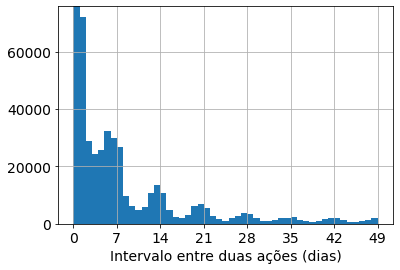

In [17]:
bins = np.arange(0,50)
counts, bins, patches = pl.hist(time_difference_all, bins=bins)
pl.xticks(np.arange(0,50, 7))
pl.grid()
pl.xlabel('Intervalo entre duas ações (dias)', fontsize=14)
pl.ylim([0, np.max(counts[1:] * 1.05)])
pl.tick_params(labelsize=14)
pl.show()

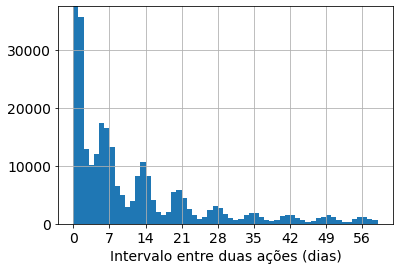

In [20]:
# Get time difference between relevant events:
sel_tramitacoes = select_relevant_events(congresso_trams, ['situacao_descricao_situacao', 'evento', 'titulo_evento'])

time_difference_sel = get_time_interval(sel_tramitacoes)

bins = np.arange(0,60)
counts, bins, patches = pl.hist(time_difference_sel, bins=bins)
pl.xticks(np.arange(0,60, 7))
pl.grid()
pl.xlabel('Intervalo entre duas ações (dias)', fontsize=14)
pl.ylim([0, np.max(counts[1:] * 1.05)])
pl.tick_params(labelsize=14)
pl.show()

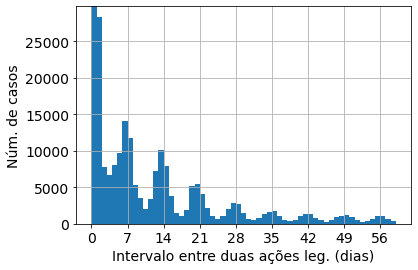

In [21]:
# Get time difference between relevant events:
sel_tramitacoes = select_relevant_events(congresso_trams, ['evento', 'titulo_evento'])

time_difference_sel = get_time_interval(sel_tramitacoes)

bins = np.arange(0,60)
counts, bins, patches = pl.hist(time_difference_sel, bins=bins)
pl.xticks(np.arange(0,60, 7))
pl.grid()
pl.xlabel('Intervalo entre duas ações leg. (dias)', fontsize=14)
pl.ylim([0, np.max(counts[1:] * 1.05)])
pl.tick_params(labelsize=14)
pl.ylabel('Núm. de casos', fontsize=14)
pl.show()

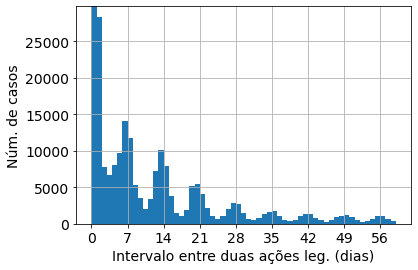

In [22]:
# Get time difference between relevant events:
sel_tramitacoes = select_relevant_events(congresso_trams, ['evento'])

time_difference_sel = get_time_interval(sel_tramitacoes)

bins = np.arange(0,60)
counts, bins, patches = pl.hist(time_difference_sel, bins=bins)
pl.xticks(np.arange(0,60, 7))
pl.grid()
pl.xlabel('Intervalo entre duas ações leg. (dias)', fontsize=14)
pl.ylim([0, np.max(counts[1:] * 1.05)])
pl.tick_params(labelsize=14)
pl.ylabel('Núm. de casos', fontsize=14)
pl.show()

#### Intervalo típico entre eventos

In [18]:
congresso_trams['sigla_tipo'].unique()

array(['PL', 'PLS', 'PEC', 'PLP', 'PLV', 'PLN', 'MPV', nan, 'PDS', 'PLC'],
      dtype=object)

In [193]:
casa = ['camara', 'senado']
sigla_tipo = ['PL', 'PLS', 'PLC', 'PLN']
sigla_tipo = ['PL', 'PLS', 'PLC', 'PLN', 'PLP']
#sigla_tipo = ['MPV', 'PLV']
#sigla_tipo = ['PEC']
#sigla_tipo = ['PLP']

# Seleciona apenas eventos tagueados:
sel_tramitacoes = select_relevant_events(congresso_trams.loc[congresso_trams['casa'].isin(casa) & congresso_trams['sigla_tipo'].isin(sigla_tipo)], ['evento'])
# Calcula o intervalo de tempo entre eventos:
time_difference_sel = get_time_interval(sel_tramitacoes, name='sel_delta_days')
sel_tramitacoes = sel_tramitacoes.join(time_difference_sel)
# Marca o evento anterior:
prev_evento = xu.return_previous_entries(sel_tramitacoes, 'unique_id_leggo', ['data', 'sequencia'], 'evento')
sel_tramitacoes = sel_tramitacoes.join(prev_evento)

print('# proposições:', sel_tramitacoes['unique_id_leggo'].nunique())

# proposições: 38408


In [194]:
# Cria pivot table que conta número de exemplos de cada par de eventos sucessivos:
event_pair_counts = sel_tramitacoes.pivot_table(index='evento', columns='prev_evento', values='sel_delta_days', aggfunc='count')
col_name = event_pair_counts.columns.name
idx_name = event_pair_counts.index.name
# Acrescenta colunas para eventos prévios não existentes:
missing_cols = list(set(event_pair_counts.index) - set(event_pair_counts.columns))
missing_prev_eventos = pd.DataFrame(index=event_pair_counts.index, columns=missing_cols).astype(float)
event_pair_counts = event_pair_counts.join(missing_prev_eventos)
# Acrescenta linhas para eventos correntes não existentes
missing_rows = list(set(event_pair_counts.columns) - set(event_pair_counts.index))
missing_eventos = pd.DataFrame(index=missing_rows, columns=event_pair_counts.columns).astype(float)
event_pair_counts = pd.concat([event_pair_counts, missing_eventos])
# Recoloca os nomes dos index e das colunas:
event_pair_counts.columns.name = col_name
event_pair_counts.index.name = idx_name

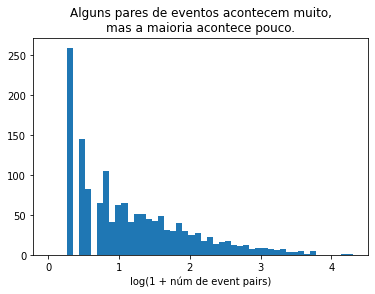

In [195]:
# Histograma do número de ocorrências de pares de eventos
event_pair_counts_stack = event_pair_counts.transpose().stack()
pl.hist(np.log10(1 + event_pair_counts_stack), bins=50)
pl.title('Alguns pares de eventos acontecem muito,\nmas a maioria acontece pouco.')
pl.xlabel('log(1 + núm de event pairs)')
pl.show()

In [196]:
# Ordena matriz de contagem de pares de eventos por maiores números de ocorrência.
prev_events_by_freq = list(event_pair_counts.sum().sort_values(ascending=False).index)
events_by_freq      = list(event_pair_counts.transpose().sum().sort_values(ascending=False).index)
sorted_event_pair_counts = event_pair_counts.sort_values(prev_events_by_freq, ascending=False).transpose().sort_values(events_by_freq, ascending=False)

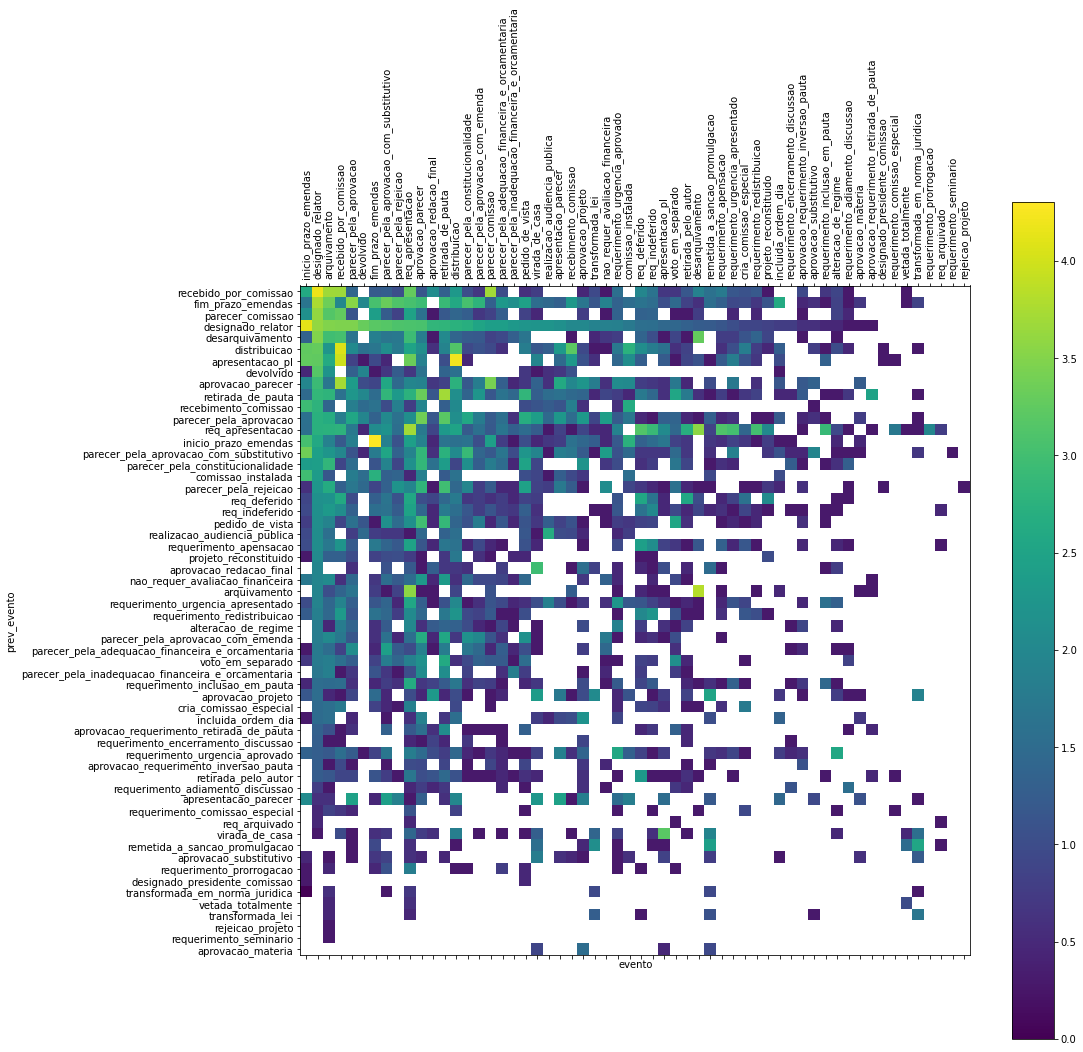

In [197]:
# Matriz que mostra o número de vezes que cada par sucessivo de eventos aconteceu:
pl.figure(figsize=(15,15))
pl.matshow(np.log10(1 + sorted_event_pair_counts.values), fignum=1)
pl.xticks(range(len(sorted_event_pair_counts.columns)), sorted_event_pair_counts.columns, rotation=90)
pl.xlabel(sorted_event_pair_counts.columns.name)
pl.yticks(range(len(sorted_event_pair_counts.index)), sorted_event_pair_counts.index)
pl.ylabel(sorted_event_pair_counts.index.name)
pl.colorbar()
pl.show()

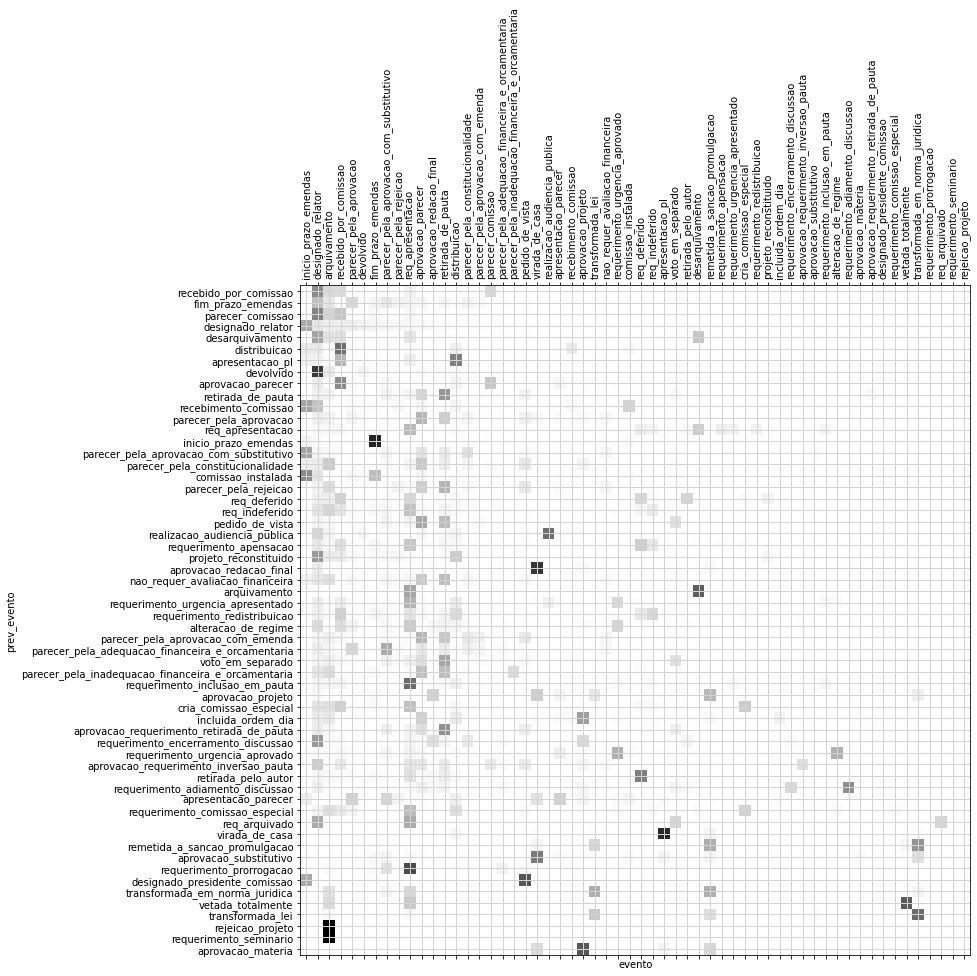

In [198]:
# Matriz que mostra a fração de vezes que o evento `prev_evento` é sucedido por `evento`:
freq_prev_to_curr = sorted_event_pair_counts.div(sorted_event_pair_counts.sum(axis=1).clip(lower=1), axis=0).fillna(0)

pl.figure(figsize=(12,12))
pl.matshow(freq_prev_to_curr, fignum=1, cmap='binary')
pl.xticks(range(len(freq_prev_to_curr.columns)), freq_prev_to_curr.columns, rotation=90)
pl.xlabel(freq_prev_to_curr.columns.name)
pl.yticks(range(len(freq_prev_to_curr.index)), freq_prev_to_curr.index)
pl.ylabel(freq_prev_to_curr.index.name)
pl.grid(linewidth=1, color='lightgray')
pl.show()

#### Grafo das tramitações

In [199]:
import networkx as nx

In [200]:
# Número de vezes que um evento aparece como ponto de chegada:
sink_counts   = sorted_event_pair_counts.sum(axis=0)
sink_counts.name = 'sink_counts'
# Número de vezes que um evento aparece como ponto de saída:
source_counts = sorted_event_pair_counts.sum(axis=1)
source_counts.name = 'source_counts'

In [201]:
# Diferença entre entrada e saída:
src_sink_counts = sink_counts.reset_index().join(source_counts, on='evento')
src_sink_counts['abs_diff'] = (src_sink_counts['source_counts'] - src_sink_counts['sink_counts']).abs()

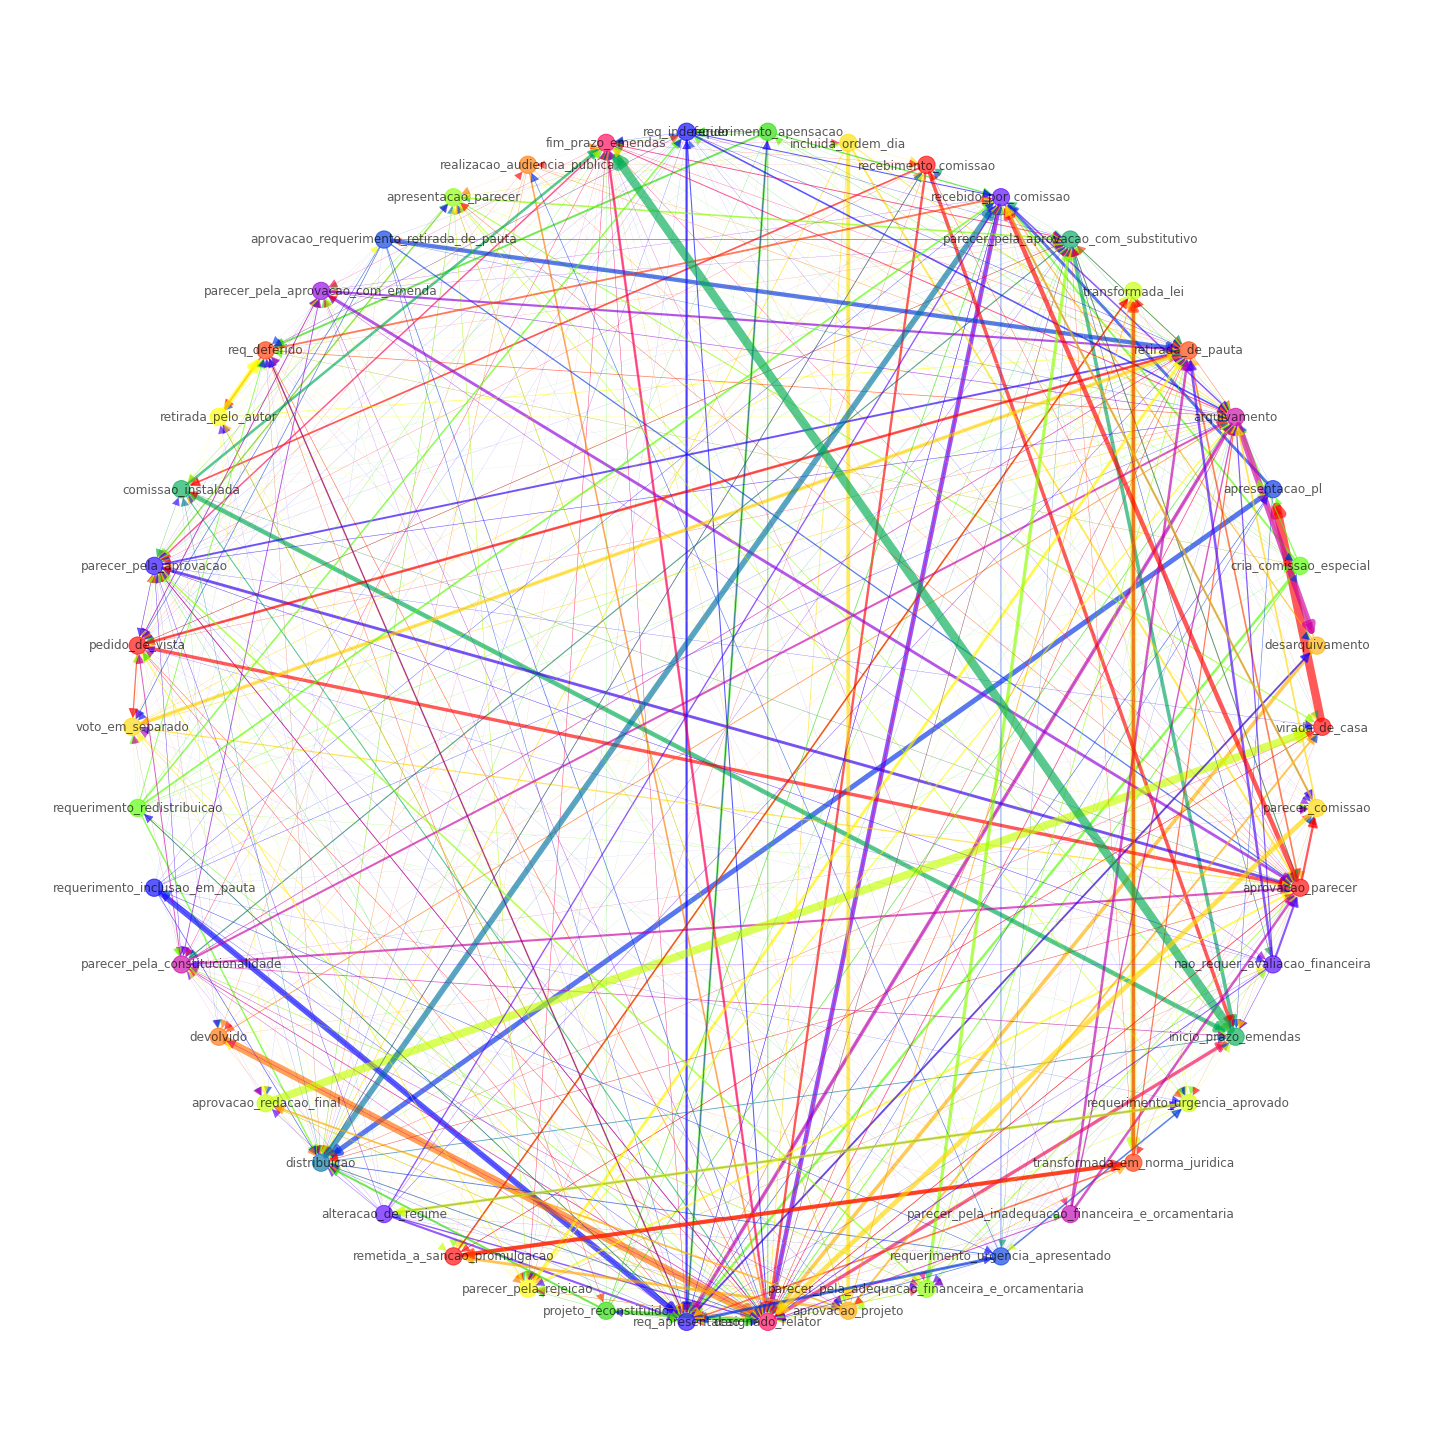

In [207]:
min_inbound  = 0.005
min_outbound = 0.005
min_freq     = 0.005

#cmap = pl.get_cmap('hsv')
cmap = pl.get_cmap('prism')

# Seleciona nós com um mínimo de atividade:
selected_sinks   = sink_counts.loc[sink_counts / sink_counts.max() >= min_inbound]
selected_sources = source_counts.loc[source_counts / source_counts.max() >= min_outbound]
node_list = list(set(selected_sinks.index) | set(selected_sources.index))
# Filtra matriz de adjacência por nós selecionados:
weighted_adjacency_matrix = (freq_prev_to_curr.loc[node_list, node_list])

# Zera bordas com pouca frequência:
weighted_adjacency_matrix = weighted_adjacency_matrix * (weighted_adjacency_matrix >= min_freq).astype(int)

# Cria grafo:
G = nx.from_pandas_adjacency(weighted_adjacency_matrix, create_using=nx.DiGraph)

# Define color dict for the nodes:
source_colors = {n: cmap(i / len(G.nodes)) for i, n in enumerate(G.nodes)}

# Get weights of each edge and format arrows:
edges = G.edges()
weights = [G[u][v]['weight'] * 10 for u,v in edges]
edge_colors = [source_colors[u] for u,v in edges]

pl.figure(figsize=(20,20))
layout = nx.circular_layout(G)
nx.draw(G, layout, with_labels=True, width=weights, edge_color=edge_colors, arrowsize=20, alpha=0.65, node_color=list(source_colors.values()))

# Draw edge labels using layout and list of labels
#nx.draw_networkx_edge_labels(G, pos=layout, width=weights)

pl.show()

#### Distribuição de tempo entre eventos

In [262]:
def plot_time_interval(time_interval):
    pl.figure(figsize=(30,4))

    pl.subplot(1,4,1)
    max_days = 365 * 4
    sel_time_interval = time_interval.loc[time_interval <= max_days]
    pl.hist(sel_time_interval, bins=50)
    pl.xlim([0, max_days])
    pl.title('{} --> {}'.format(prev_ev, curr_ev))
    pl.xlabel('# dias entre eventos (grande escala)')

    pl.subplot(1,4,2)
    max_days = 60
    sel_time_interval = time_interval.loc[time_interval <= max_days]
    pl.hist(sel_time_interval, bins=50)
    pl.xlim([0, max_days])
    pl.title('{} --> {}'.format(prev_ev, curr_ev))
    pl.xlabel('# dias entre eventos (detalhe)')

    pl.subplot(1,4,3)
    max_days = 365 * 4
    sel_time_interval = time_interval.loc[time_interval <= max_days]
    pl.hist(sel_time_interval, bins=50, cumulative=True, density=True)
    pl.xlim([0, max_days])
    pl.title('{} --> {}'.format(prev_ev, curr_ev))
    pl.xlabel('# dias entre eventos (grande escala)')

    pl.subplot(1,4,4)
    max_days = 60
    #sel_time_interval = time_interval.loc[time_interval <= max_days]
    sel_time_interval = time_interval
    pl.hist(sel_time_interval, bins=np.arange(0,356 * 4), cumulative=True, density=True)
    pl.xlim([0, max_days])
    pl.title('{} --> {}'.format(prev_ev, curr_ev))
    pl.xlabel('# dias entre eventos (detalhe)')

    pl.tight_layout()
    pl.show()


In [263]:
# Cria lista de pares de eventos que mais acontecem:
most_common_event_pairs = event_pair_counts_stack.sort_values(ascending=False).reset_index()

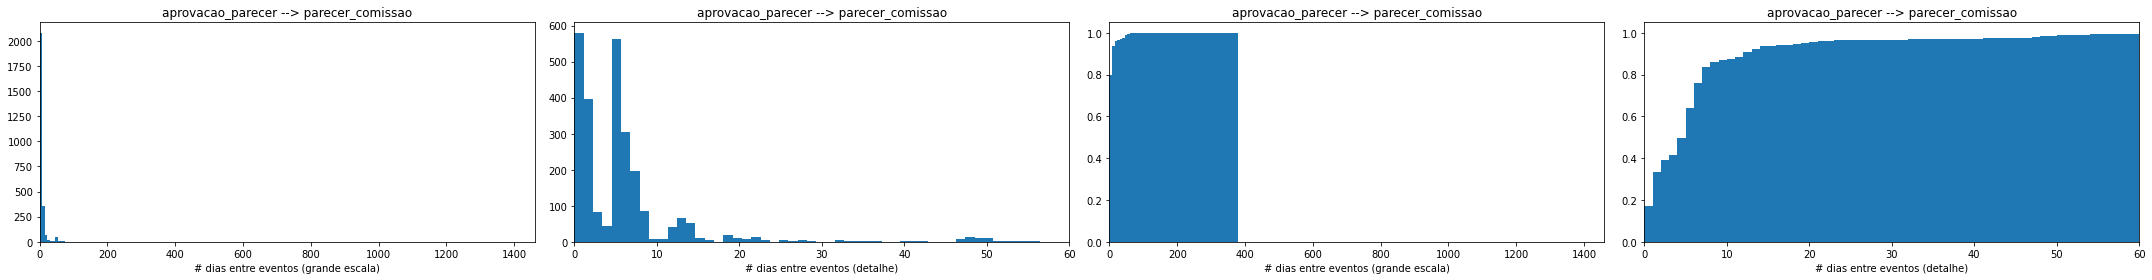

* aprovacao_parecer --> parecer_comissao ( `i = 23` );


In [289]:
i = 23
prev_ev = most_common_event_pairs['prev_evento'].iloc[i]
curr_ev = most_common_event_pairs['evento'].iloc[i]
time_interval = sel_tramitacoes.loc[(sel_tramitacoes['prev_evento'] == prev_ev) & (sel_tramitacoes['evento'] == curr_ev), 'sel_delta_days']
plot_time_interval(time_interval)
print('* {} --> {} ( `i = {}` );'.format(prev_ev, curr_ev, i))

**Notas**

* Uma proposição pode ser recebida pela comissão e ficar parada até o final da legislatura e ser arquivada ( `i = 12` );
* Um PL pode demorar um pouco para receber relator, após ingressar numa comissão ( `i = 2` );
* Um PL apresentado pode demorar um pouco para chegar numa comissão ( `i = 5` );
* Entre fim de prazo p/ ementas e designação de relator, o PL pode ficar esquecido ( `i = 7` );
* Entre fim de prazo p/ ementas e apresentação de parecer, o PL pode ficar esquecido ( `i = 7` );
* Um PL pode ficar sendo retirado de pauta.
* PLs desarquivados em geral levam tempo para receber um relator.

**Ações praticamente imediatas**

* recebido_por_comissao --> parecer_comissao ( `i = 11` );
* inicio_prazo_emendas --> fim_prazo_emendas (`i=0`);
* designado_relator --> inicio_prazo_emendas  (`i = 3`);
* distribuicao --> recebido_por_comissao (`i = 4`);
* aprovacao_parecer --> recebido_por_comissao (`i = 8`);
* recebido_por_comissao --> parecer_comissao (`i = 11`);

#### Verificando a tramitação de proposições específicas

In [78]:
id_leggo = congresso_trams['unique_id_leggo'].sample().iloc[0]
#tram = select_one_tramitacao(congresso_trams, 'be89b46234675e5320761fb034215042')
tram = select_one_tramitacao(congresso_trams, id_leggo)

In [79]:
#print_tramitacao(congresso_trams.loc[~congresso_trams['evento'].isnull() & congresso_trams['titulo_evento'].isnull()].sample(30))

In [80]:
print_tramitacao(tram)

100122 (senado) --> https://www25.senado.leg.br/web/atividade/materias/-/materia/100122
529884 (camara) --> https://www.camara.leg.br/proposicoesWeb/fichadetramitacao?idProposicao=529884
(sequencia) data - [casa] origem_tramitacao_local_nome_casa_local >> [local] sigla_local : global <fase> - descricao_situacao ! [evento] titulo_evento - tipo_documento nivel (status)
texto_tramitacao

(1) 2011-05-05 00:00:01 - [senado] nan >> [Mesa - Senado] PLEG : nan <nan> - nan ! [apresentacao_pl] Apresentação de Projeto de Lei - nan 3 (Arquivada)
Este processo contém 12 (doze)  folhas numeradas e rubricadas.

(2) 2011-05-05 00:00:02 - [senado] nan >> [Mesa - Senado] ATA-PLEN : nan <nan> - nan ! [distribuicao] Distribuição - nan 3 (Arquivada)
Leitura.
Às Comissões de Constituição, Justiça e Cidadania e de Assuntos Econômicos.

(3) 2011-05-06 00:00:01 - [senado] nan >> [CCJ] CCJ : - Revisão (Senado) <Recebimento> - AGUARDANDO DESIGNAÇÃO DO RELATOR ! [nan] nan - nan 4 (Arquivada)
Recebido nesta Comiss

## Exploração dos dados

In [2]:
# Carrega lista de arquivos
data_files = sorted(glob('../dados/proposicoes_processadas_2011_2021_part01/*.csv'))
data_files

['../dados/proposicoes_processadas_2011_2021_part01/hists_temperatura.csv',
 '../dados/proposicoes_processadas_2011_2021_part01/interesses.csv',
 '../dados/proposicoes_processadas_2011_2021_part01/proposicoes.csv',
 '../dados/proposicoes_processadas_2011_2021_part01/proposicoes_nao_capturadas.csv',
 '../dados/proposicoes_processadas_2011_2021_part01/trams.csv']

### Proposições não capturadas

**Conclusões**

* Cada linha na tabela é uma proposição;
* A grande maioria delas são medidas provisórias. Existem medidas provisórias que são capturadas, mas são a minoria.

In [3]:
prop_nao_capturadas = pd.read_csv('../dados/proposicoes_processadas_2011_2021_part01/proposicoes_nao_capturadas.csv')
print('# de proposições não capturadas:', len(prop_nao_capturadas))
assert prop_nao_capturadas.id_leggo.nunique() == len(prop_nao_capturadas)
prop_nao_capturadas.sample(5)

# de proposições não capturadas: 794


,proposicao,id_camara,id_senado,row,id_leggo
589,MPV 628/2013,602714.0,NaN,31086,34e9dca8d9dee321686cafa677ac00d1
640,MPV 935/2020,NaN,141374.0,33318,f119ce00125eb64474ea521e45d35c9a
737,MPV 866/2018,2190190.0,NaN,38498,32c1fdb93fe1a325d1678b3937b429b9
293,MPV 1021/2020,2268414.0,NaN,15766,e06bce83b0088e22ca82039c8c6298b2
0,MPV 823/2018,NaN,132477.0,59,a8908ad9cc15129ed904f92c2d9fbaa9


In [4]:
# Tipos de proposições não capturadas:
prop_nao_capturadas['proposicao'].str.extract(r'^([A-Z]+)')[0].value_counts()

MPV    776
PL      10
PLS      8
Name: 0, dtype: int64

### Tramitações e eventos

In [119]:
# Carrega e prepara os dados de tramitações:
trams = pd.read_csv('../dados/proposicoes_processadas_2011_2021_part01/trams.csv', low_memory=False)
trams['data'] = pd.to_datetime(trams['data'])

In [120]:
# Confirma que algumas colunas estão 100% vazias:
assert trams['ambito'].isnull().sum() == len(trams)
assert trams['uri_ultimo_relator'].isnull().sum() == len(trams)

# Confirma que uma id_ext corresponde à tramitação em uma casa específica:
assert trams.groupby('id_ext')['casa'].nunique().sort_values().max() == 1

In [121]:
# Todas as colunas não vazias:
trams_cols = ['id_ext', 'casa', 'data', 'sequencia', 'texto_tramitacao', 'sigla_local', 'id_situacao', 'descricao_situacao', 'link_inteiro_teor',
              'evento', 'local', 'tipo_documento', 'titulo_evento', 'nivel', 'temperatura_local', 'temperatura_evento',
              'fase', 'situacao_descricao_situacao', 'data_audiencia', 'global', 'origem_tramitacao_local_nome_casa_local', 'status']
# Colunas que identificam uma proposição:
tag_cols  = ['id_ext', 'casa']
# Colunas que variam ao longo da tramitação:
hist_cols = ['sequencia', 'data', 'texto_tramitacao', 'sigla_local', 'descricao_situacao', 'evento', 
             'local', 'tipo_documento', 'titulo_evento', 'nivel', 'fase', 'situacao_descricao_situacao',
             'global', 'origem_tramitacao_local_nome_casa_local', 'status']
# Colunas com informações curtas que vão no cabeçalho de cada instante da tramitação:
header_cols = ['sequencia', 'data', 
                 'origem_tramitacao_local_nome_casa_local', 'local', 'sigla_local',
                 'global', 'fase', 'situacao_descricao_situacao', 'descricao_situacao', 
                 'evento', 'titulo_evento', 
                 'tipo_documento', 'nivel', 'status']

#### Escala de tempo entre eventos

#### Leitura das tramitações

In [122]:
# Colunas na ordem que são impressas:
header =  '  '.join(['{:4}'] * len(header_cols))
formatted_print(header.format(*hist_cols), bold=True)

sequencia  data  texto_tramitacao  sigla_local  descricao_situacao  evento  local  tipo_documento  titulo_evento  nivel  fase  situacao_descricao_situacao  global  origem_tramitacao_local_nome_casa_local


In [17]:
# Select a random proposição:
random_id_ext = trams['id_ext'].sample().iloc[0]
#random_id_ext = 590549
test = trams.loc[trams['id_ext'] == random_id_ext].sort_values(['data', 'sequencia'])

In [18]:
# Print tramitação:
print_header(test)
print('')
for i in range(len(test)):
    row = test.iloc[i]
    print_one_event(row)
    print('')

2193947 (camara) --> https://www.camara.leg.br/proposicoesWeb/fichadetramitacao?idProposicao=2193947

(2) 2019-03-14 00:00:00 - nan >> [CD-MESA-PLEN] PLEN : nan <nan> - [nan] nan ! [nan] nan - nan 4 (Ativa)
Proposição fora da numeração sequencial em razão da implantação eletrônica no Sistema em 14/03/2019 (revisão do Sileg).

(1) 2019-03-14 11:23:00 - nan >> [CD-MESA-PLEN] PLEN : nan <nan> - [nan] nan ! [apresentacao_pl] Apresentação de Projeto de Lei - nan 3 (Ativa)
Apresentação do Projeto de Lei n. 1484/2019, pelo Deputado Heitor Schuch (PSB-RS), que: "Determina que empresas de direito público, no âmbito federal, ao patrocinarem clubes de futebol, destinem 5% do valor do patrocínio para ser utilizado em prol do futebol feminino".

(3) 2019-03-14 11:23:00 - nan >> [CD-MESA-PLEN] SEPRO : nan <nan> - [nan] nan ! [nan] nan - nan 4 (Ativa)
Realizar o Encaminhamento para SECAP(SGM)

(4) 2019-03-14 11:23:00 - nan >> [CD-MESA-PLEN] CEDI : nan <nan> - [nan] nan ! [nan] nan - nan 4 (Ativa)
Enc

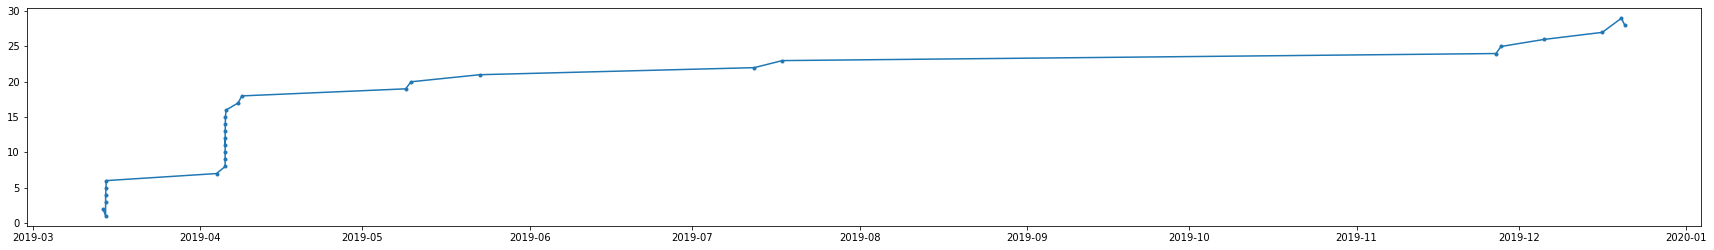

In [19]:
prop_tram = trams.loc[trams['id_ext'] == random_id_ext]
pl.figure(figsize=(30,4))
pl.plot(prop_tram['data'], prop_tram['sequencia'], marker='.')
pl.show()

### Proposições

**Conclusões**

* Existem medidas provisórias que são capturadas, mas elas são minoria;
* A lista apenas inclui as proposições capturadas.
* O status "Aprovada" e "Lei" significam a mesma coisa (mas Aprovada).
* O status "Caducou" apenas é válido para MPVs.
* PLNs traram quase que exclusivamente de orçamento e são tipicamente aprovados.

In [5]:
proposicoes = pd.read_csv(data_files[2])
proposicoes.sample(5)

,id_ext,sigla_tipo,numero,ementa,data_apresentacao,casa,casa_origem,autor_nome,autor_uf,autor_partido,regime_tramitacao,forma_apreciacao,relator_id,relator_id_parlametria,id_leggo,status
26823,2192171,PL,813.0,"Altera a Lei nº 12.505, de 11 de outubro de 20...",2019-02-14T11:34:00Z,camara,camara,Subtenente Gonzaga,MG,PDT,Ordinária,Plenário,141421.0,1141421.0,6f9fcf1ab366a723573318459cc96748,Ativa
36545,501460,PL,1285.0,Cria o Banco de Prótese Mamária.,2011-05-10T17:15:00Z,camara,camara,FELIPE BORNIER,RJ,PROS,Ordinária,Conclusiva,73434.0,173434.0,76a50fb0714db768814aa62bf8185b51,Ativa
17244,540579,PEC,160.0,Acrescenta alínea ao inciso VI do art. 150 da ...,2012-04-10T18:27:00Z,camara,camara,WELLINGTON FAGUNDES,MT,PR,Especial,Plenário,160559.0,1160559.0,001430d890c59a81a7c09da0c4f77e77,Arquivada
14838,140556,PL,173.0,"Autoriza transferência de capital, a título de...",2020-02-06T00:00:00Z,senado,camara,Câmara dos Deputados,NaN,NaN,Ordinária,Plenário,NaN,NaN,b22ccfec4b08d875513988462e06e2ad,Ativa
28276,103540,PLS,718.0,Dispõe sobre responsabilidade civil do Estado.,2011-12-01T00:00:00Z,senado,senado,Aécio Neves PSDB / MG,NaN,NaN,Ordinária,Plenário,3361.0,23361.0,a567c4c7fddbf59bfd884ffa83e439ad,Arquivada


In [6]:
xu.checkMissing(proposicoes)

Colunas com valores faltantes:
                    coluna      N      %
2                   numero      1      0
3                   ementa      2      0
6              casa_origem    172   0.41
7               autor_nome     77   0.18
8                 autor_uf  11464  27.04
9            autor_partido  11464  27.04
12              relator_id  20335  47.97
13  relator_id_parlametria  20335  47.97


In [7]:
# Algumas proposições aparecem duas vezes, provavelmente relacionados a duas casas:
proposicoes['id_leggo'].value_counts().sort_values()

e1fc5b3a9e4a66f92232e70fcd8df08a    1
cecac6c9ea1eaa21bce74918f92834c8    1
c2d8bc656998ad5455a5775a82fb34ad    1
e6cb27f113e88f7de3c997ca7c13af90    1
ff63c1459402251444fcef1c7ece609f    1
                                   ..
688e31962325d003986dbd3b94a4588d    2
b445e976c058ead5cb7c978c5453b483    2
9077a3ebf84aa3aae483882187a5167f    2
f6a610651a9eb7dfe8bf23a70622f5bb    2
5bffcafc8d3b572fb457537dcab4665e    2
Name: id_leggo, Length: 40585, dtype: int64

In [8]:
# Número de proposições por tipo:
proposicoes['sigla_tipo'].value_counts(normalize=True)

PL     0.770421
PLS    0.107206
PEC    0.042764
PLP    0.038047
PLC    0.018446
PLN    0.012053
PLV    0.009081
MPV    0.001934
PDS    0.000047
Name: sigla_tipo, dtype: float64

In [9]:
# Teste se proposições não capturadas também aparecem no proposições:
set(proposicoes['id_leggo']) & set(prop_nao_capturadas['id_leggo'])

set()

In [10]:
#xu.mapUnique(proposicoes)
for col in ['forma_apreciacao', 'regime_tramitacao', 'status']:
    print(xu.Bold(col))
    xu.unique(proposicoes[col])

forma_apreciacao
3: Conclusiva | Indefinido | Plenário
regime_tramitacao
5: Especial | Indefinido | Ordinária | Prioridade | Urgência
status
5: Aprovada | Arquivada | Ativa | Caducou | Lei


In [11]:
# O status caducou só vale para MPVs:
proposicoes.loc[proposicoes['status'] == 'Caducou', 'sigla_tipo'].value_counts()

MPV    5
PLV    4
Name: sigla_tipo, dtype: int64

In [12]:
# Vamos selecionar apenas proposições que já pararam de tramitar e vamos ignorar PLNs (que tratam de orçamento e tipicamente são aprovados):
prop_sel = proposicoes.loc[(proposicoes['status'] != 'Ativa') & (proposicoes['sigla_tipo'] != 'PLN')].copy()
prop_sel['status'] = prop_sel['status'].map(xu.translate_dict({'Aprovada':'Lei', 'Caducou':'Arquivada'}))

In [13]:
# A maioria das proposições são arquivadas:
prop_sel['status'].value_counts(normalize=True)

Arquivada    0.909557
Lei          0.090443
Name: status, dtype: float64

In [14]:
# A maioria das proposições na câmara são conclusivas:
prop_sel.loc[prop_sel['casa'] == 'camara']['forma_apreciacao'].value_counts(normalize=True)

Conclusiva    0.758515
Plenário      0.234673
Indefinido    0.006812
Name: forma_apreciacao, dtype: float64

In [15]:
def category_fraction_in_groups(df, group_cols, category_col):
    """
    Count the frequency at which each class in column 
    `category_col` (str) appears inside groups defined by 
    the values in columns `group_cols` (list of str), using
    microdata in `df` (DataFrame).
    
    Returns a DataFrame where `group_cols` are the index and 
    the frequency, along other statistics, for each class, 
    are the columns.
    """
    
    # Count the occurences of each category under column `category_col`, for each group:
    stacked_counts = xu.count_occurences_in_groups(df, group_cols, category_col)
    
    # Split the cetegory counts into their own columns:
    column_counts  = stacked_counts.pivot(index=group_cols, columns=category_col, values='counts')
    cat_columns    = column_counts.columns
    
    # Get the total counts in each group:
    column_counts['Total'] = column_counts.sum(axis=1)
    
    # Compute the fraction and its error for each category:
    for col in cat_columns:
        column_counts[col + '_dev']  = np.sqrt(column_counts[col])
        column_counts[col + '_frac'] = column_counts[col] / column_counts['Total']
        column_counts[col + '_err']  = column_counts[col + '_dev'] / column_counts['Total']
    
    return column_counts

In [16]:
def plot_class_freq_in_groups(df, group_cols, category_col, plot_class):

    cat_freq = category_fraction_in_groups(df, group_cols, category_col)

    sorted_freq = cat_freq.sort_values(plot_class + '_frac')

    cat_names = sorted_freq.index
    col_names = sorted_freq.index.names
    
    labels = ['\n'.join([col + ': ' + cat for col, cat in zip(col_names, cats if type(cats) == tuple else [cats])]) for cats in cat_names]

    pl.barh(labels, sorted_freq[plot_class + '_frac'] * 100, color='brown', alpha=0.5, xerr=sorted_freq[plot_class + '_err'] * 100, ecolor='brown')
    pl.xlabel('% de casos nos quais\n{} = {}'.format(category_col, plot_class), fontsize=12)

In [17]:
prop_sel.head()

,id_ext,sigla_tipo,numero,ementa,data_apresentacao,casa,casa_origem,autor_nome,autor_uf,autor_partido,regime_tramitacao,forma_apreciacao,relator_id,relator_id_parlametria,id_leggo,status
3,2086224,PL,5441.0,Torna obrigatória toda empresa e/ou indústria ...,2016-06-01T11:37:00Z,camara,camara,JOÃO FERNANDO COUTINHO,PE,PROS,Ordinária,Conclusiva,178834.0,1178834.0,e8c8f673b4240f4bdd5a8d12b8b6bd96,Arquivada
7,491331,PL,214.0,"Altera a Lei nº 8.078, de 11 de setembro de 19...",2011-02-08T17:40:00Z,camara,camara,SANDES JÚNIOR,GO,PP,Ordinária,Conclusiva,74106.0,174106.0,992ed7e96f6d78ce3f63e382094ab11c,Arquivada
8,533876,PL,3118.0,Dispõe sobre a prestação de auxílio financeiro...,2012-02-03T10:58:00Z,camara,camara,SANDRA ROSADO,RN,PSB,Ordinária,Conclusiva,160607.0,1160607.0,ba4fcff988e2b60bb2ec80dcf8d44d80,Arquivada
9,1618389,PL,2626.0,"Altera a Lei n.º 10.260, de 12 de julho de 200...",2015-08-12T19:12:00Z,camara,camara,KAIO MANIÇOBA,PE,SOLIDARIEDADE,Ordinária,Conclusiva,178929.0,1178929.0,80dcd91a4406b5a112b7f04c7ba813b2,Arquivada
13,533836,PL,3111.0,Torna obrigatória a existência de ambulância d...,2012-02-02T17:26:00Z,camara,camara,Roberto de Lucena,SP,PODE,Ordinária,Conclusiva,73891.0,173891.0,73dbcc95bc51c995e96c3238eaac65a1,Arquivada


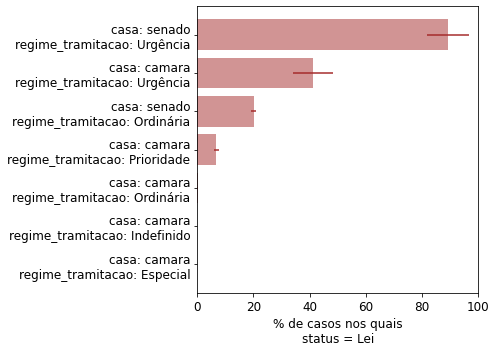

In [19]:
pl.figure(figsize=(7,5))
group_cols = ['casa', 'regime_tramitacao']
plot_class_freq_in_groups(prop_sel, group_cols, 'status', 'Lei')
pl.xlim([0, 100])
pl.tick_params(labelsize=12)
pl.tight_layout()
#pl.savefig('../resultados/frac_virou_lei_por_{}.png'.format('+'.join(group_cols)))
pl.show()

In [20]:
category_fraction_in_groups(prop_sel, group_cols, 'status')

status                    Arquivada  Lei  Total  Arquivada_dev  \
casa   regime_tramitacao                                         
camara Especial                 318    0    318      17.832555   
       Indefinido                42    0     42       6.480741   
       Ordinária               4814    6   4820      69.382995   
       Prioridade               570   42    612      23.874673   
       Urgência                  47   33     80       6.855655   
senado Ordinária               2358  591   2949      48.559242   
       Urgência                  17  140    157       4.123106   

status                    Arquivada_frac  Arquivada_err    Lei_dev  Lei_frac  \
casa   regime_tramitacao                                                       
camara Especial                 1.000000       0.056077   0.000000  0.000000   
       Indefinido               1.000000       0.154303   0.000000  0.000000   
       Ordinária                0.998755       0.014395   2.449490  0.001245   
       Prioridade               0.931373       0.039011   6.480741  0.068627   
       Urgência                 0.587500       0.085696   5.744563  0.412500   
senado Ordinária                0.799593       0.016466  24.310492  0.200407   
       Urgência                 0.108280       0.026262  11.832160  0.891720   

status                     Lei_err  
casa   regime_tramitacao            
camara Especial           0.000000  
       Indefinido         0.000000  
       Ordinária          0.000508  
       Prioridade         0.010589  
       Urgência           0.071807  
senado Ordinária          0.008244  
       Urgência           0.075364

### Histórico das temperaturas

In [12]:
hist_temperatura = pd.read_csv(data_files[0])
hist_temperatura.sample(5)

,id_leggo,periodo,temperatura_periodo,temperatura_recente
34222,3662e7e5efd17d52acad9819aba150c3,2019-05-13T00:00:00Z,0.0,0.45
8849562,7ae1ef58deb30239acdc781d0a8bba4a,2019-08-26T00:00:00Z,0.0,0.00
1395442,49f3a44947aee0dc19699d64c4515c2a,2018-07-30T00:00:00Z,0.0,0.03
5190234,fe5d62532adfa8bb6749c94bc5d1b1ab,2021-02-15T00:00:00Z,0.0,0.00
2337716,64dbe8cb365435bd267fc4941c120d25,2020-10-05T00:00:00Z,0.0,0.00


In [10]:
xu.checkMissing(hist_temperatura)

Colunas com valores faltantes:
    coluna   N  %
1  periodo  17  0
